In [1]:
import pandas as pd
import numpy as np

## Reading

In [2]:
PROFILE_DATA_PATH = "profile_data"
DIARY_PATH = f"{PROFILE_DATA_PATH}/diary.csv"
RATINGS_PATH = f"{PROFILE_DATA_PATH}/ratings.csv"
REVIEWS_PATH = f"{PROFILE_DATA_PATH}/reviews.csv"
WATCHED_PATH = f"{PROFILE_DATA_PATH}/watched.csv"
WATCHLIST_PATH = f"{PROFILE_DATA_PATH}/watchlist.csv"

In [3]:
diary     = pd.read_csv(DIARY_PATH    )
ratings   = pd.read_csv(RATINGS_PATH  )

reviews   = pd.read_csv(REVIEWS_PATH  )
watched   = pd.read_csv(WATCHED_PATH  )
watchlist = pd.read_csv(WATCHLIST_PATH)

In [4]:
dfs = {"diary": diary, "ratings": ratings, "reviews": reviews, "watched": watched, "watchlist": watchlist}

In [5]:
for name, df in dfs.items():
    for col in df.columns:
        s = df[col].isna().sum()
        if(s > 0):
            print(f"Found {s} NaN values in column {col} in {name}.")

Found 175 NaN values in column Rewatch in diary.
Found 133 NaN values in column Tags in diary.
Found 97 NaN values in column Rewatch in reviews.
Found 69 NaN values in column Tags in reviews.
Found 1 NaN values in column Year in watchlist.


### building the dataset

- [X] Remove Nan values
- [X] Map rewatch number of times the movie was watched
- [X] Drop unused columns
- [X] Remove duplicates
- [X] Check which movies are on rating that are not in diary
- [X] Check how movie rating changes after a rewatch (if there is a reting prior)
    - it barely changes

In [6]:
movies_ratings = set(ratings['Name'])
movies_diary= set(diary['Name'])

only_in_ratings_movies = movies_ratings - movies_ratings.intersection(movies_diary)

In [7]:
only_in_ratings_df = ratings[ratings['Name'].isin(only_in_ratings_movies)]

In [8]:
only_in_ratings_df

,Date,Name,Year,Letterboxd URI,Rating
18,2021-08-01,Jiro Dreams of Sushi,2011,https://boxd.it/2ONU,4.5
19,2021-08-01,Marriage Story,2019,https://boxd.it/hJAw,4.5
20,2021-08-01,The Meyerowitz Stories (New and Selected),2017,https://boxd.it/dSp0,4.0
21,2021-08-01,The Squid and the Whale,2005,https://boxd.it/1VAG,4.0
22,2021-08-01,Your Name.,2016,https://boxd.it/cUqs,5.0
...,...,...,...,...,...
126,2021-08-05,For a Few Dollars More,1965,https://boxd.it/29eu,4.5
127,2021-08-06,Rushmore,1998,https://boxd.it/1TAO,3.0
129,2021-08-06,Dirty Harry,1971,https://boxd.it/299E,4.0
136,2021-08-15,BlacKkKlansman,2018,https://boxd.it/hxL8,4.0


In [9]:
df = pd.concat([diary, only_in_ratings_df])

In [10]:
df

,Date,Name,Year,Letterboxd URI,Rating,Rewatch,Tags,Watched Date
0,2021-08-01,Avengers: Endgame,2019,https://boxd.it/22iXvd,4.0,NaN,NaN,2019-04-13
1,2021-08-01,The Girl Who Leapt Through Time,2006,https://boxd.it/22iXgn,4.0,NaN,NaN,2020-12-30
2,2021-08-01,Soul,2020,https://boxd.it/22iWYD,4.5,NaN,NaN,2021-01-03
3,2021-08-01,Saving Private Ryan,1998,https://boxd.it/22iWSF,4.5,NaN,NaN,2021-01-18
4,2021-08-01,Tenet,2020,https://boxd.it/22iWJj,4.0,NaN,NaN,2021-02-26
...,...,...,...,...,...,...,...,...
126,2021-08-05,For a Few Dollars More,1965,https://boxd.it/29eu,4.5,NaN,NaN,NaN
127,2021-08-06,Rushmore,1998,https://boxd.it/1TAO,3.0,NaN,NaN,NaN
129,2021-08-06,Dirty Harry,1971,https://boxd.it/299E,4.0,NaN,NaN,NaN
136,2021-08-15,BlacKkKlansman,2018,https://boxd.it/hxL8,4.0,NaN,NaN,NaN


### Cleaning and formatting

In [11]:
df['Rewatch'] = df['Rewatch'].map({'Yes': 1, np.nan: 0})
df['movie_id'] = df['Letterboxd URI'].map(lambda s: s.split('/')[-1])
df['movie_id'] = df['movie_id'].astype(str)
diary = diary.drop(columns=['Tags', 'Letterboxd URI', 'Date'])

watchlist = watchlist.dropna()

In [12]:
rewatches = df.groupby('Name').size().reset_index(name='count')

In [13]:
df = df.groupby('Name')\
     .agg(\
          {'Year': min,\
           'Rating': lambda r: list(r)[-1],\
           'Rewatch': lambda x: x.sum() + 1,\
           'Watched Date': max,\
           'movie_id': min})\
      .rename(
          columns={'Rating': 'Latest Rating', 'Rewatch': 'Times watched', 'Watched Date': 'latest Date'}
      ).reset_index()

In [57]:
df["Categorical Rating"] = pd.cut(df["Latest Rating"], bins=[0.5, 2.5, 3.5, 5.0],labels=['Bad', 'Neutral', 'Good'])
df["Decade"] = pd.cut(df["Year"],\
                      bins=[1940, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019, 2023],\
                      labels=['1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']\
                              )

In [14]:
df

,Name,Year,Latest Rating,Times watched,latest Date,movie_id
0,(500) Days of Summer,2009,4.5,2,2022-04-02,23pe3V
1,10 Things I Hate About You,1999,3.5,1,2023-04-01,43Uvux
2,12 Angry Men,1957,5.0,1,2021-08-02,22yBiD
3,1917,2019,4.0,1,NaN,jj4y
4,2001: A Space Odyssey,1968,4.5,2,2021-08-28,26hLtX
...,...,...,...,...,...,...
285,Yesterday,2019,3.0,1,2021-04-03,22iWEX
286,Your Name.,2016,5.0,1,NaN,cUqs
287,Zodiac,2007,4.5,1,NaN,27MO
288,mother!,2017,4.5,1,2021-12-28,2plM9N


### EDA

Some questions:

* How distributed is my rating; 
    * Answer: I'm biased towards rating a movie with a good grade (centered around 4/5)
* How differently rated are movies that I have rewatched
    * Answer: Equally biased towards rating as good movie, but with the mode being centered at 4.5/5.
* Do i have a bias towards a certain decade or year in ratings?
* Do i have a preference towards a certain decade or year in the decision of watching the movie?
* What day of the week have I watched more movies?
* What's the month in which have I watched more movies?
* What's the shortest i have waited among rewatches? What's the longest?

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
df.describe()

,Year,Latest Rating,Times watched
count,290.000000,290.000000,290.000000
mean,2004.437931,3.837931,1.086207
std,18.043717,0.946461,0.304776
min,1941.000000,0.500000,1.000000
25%,1996.000000,3.500000,1.000000
50%,2011.000000,4.000000,1.000000
75%,2019.000000,4.500000,1.000000
max,2023.000000,5.000000,3.000000


In [17]:
df.corr()

,Year,Latest Rating,Times watched
Year,1.000000,-0.195508,0.027718
Latest Rating,-0.195508,1.000000,0.132571
Times watched,0.027718,0.132571,1.000000


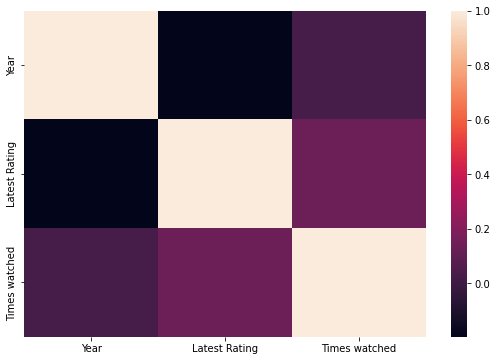

In [18]:
fig, ax =plt.subplots(figsize=(9,6))
sns.heatmap(df.corr());

### Rating

In theory, Latest rating is a continuous variable, so a histogram would be more suited. But in practice, we rate movies on a discrete categorial 0.5-5 scale with 0.5 increments. So i have decided to use a countplot for visualization.

The distribution appears to be centered at 4: not only visually, but the average is set at 3.8 and the median and mode are 4. it resembles a normal distribution slightly skewed to the right cut off right after its peak.

In [19]:
ratings = list(np.arange(0.5, 5.0, 0.5)) 

In [20]:
ratings

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

In [21]:
df['Latest Rating'].mode().values[0]

4.0

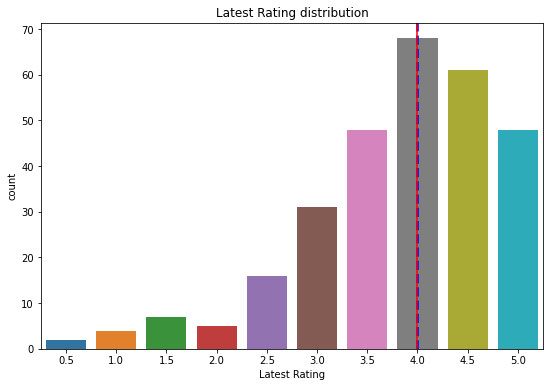

In [22]:
fig, ax =plt.subplots(figsize=(9,6))
ratings = list(np.arange(0.5, 5.0, 0.5))

plt.axvline(x=ratings.index(df['Latest Rating'].median()),
            color='blue',
            ls='--', 
            lw=2.5)


plt.axvline(x=ratings.index(df['Latest Rating'].mode().values[0]),
            color='red',
            ls='-', 
            lw=1.5)

sns.countplot(x=df['Latest Rating'], ax=ax).set(title="Latest Rating distribution");

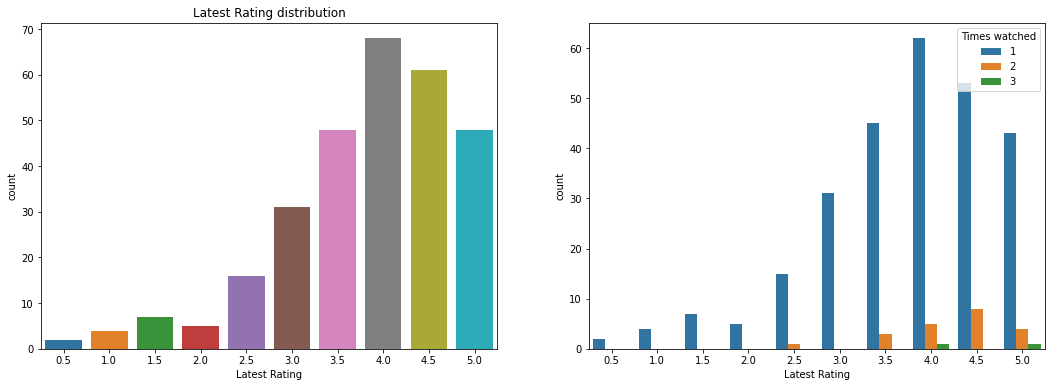

In [23]:
fig, ax =plt.subplots(1,2, figsize=(18,6))
ratings = list(np.arange(0.5, 5.0, 0.5))
sns.countplot(x=df['Latest Rating'], ax=ax[0]).set(title="Latest Rating distribution")
sns.countplot(data=df, x="Latest Rating", hue="Times watched", ax=ax[1]);

## Year

[Text(0.5, 1.0, 'Violinplot by year')]

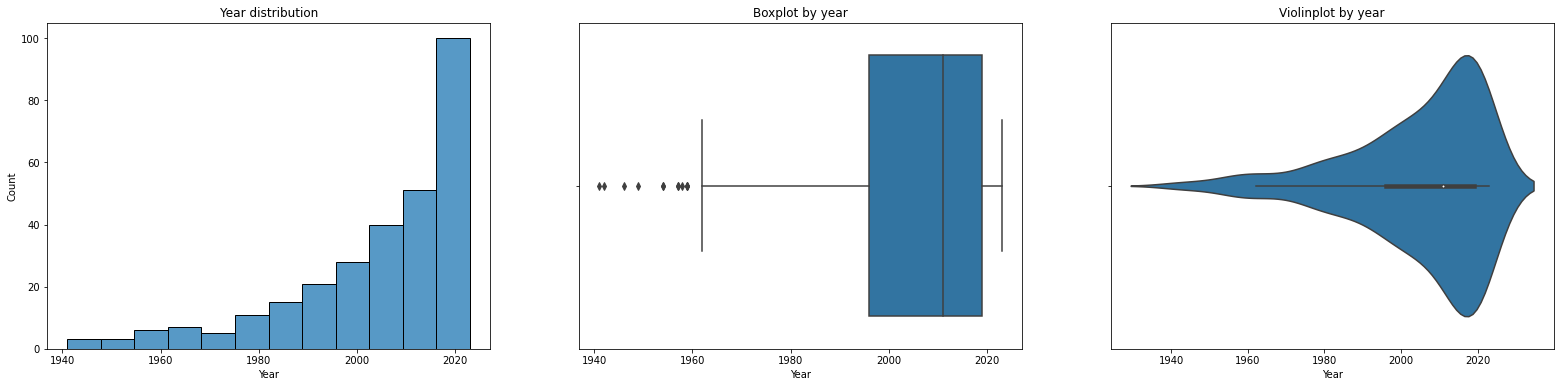

In [24]:
fig, ax =plt.subplots(1,3, figsize=(27,6))
sns.histplot(x=df['Year'], ax=ax[0]).set(title="Year distribution")
sns.boxplot(x=df['Year'], ax=ax[1]).set(title="Boxplot by year")
sns.violinplot(x=df['Year'], ax=ax[2]).set(title="Violinplot by year")

Categorizar ano em decadas? Quebrar em períodos? Usar catplot?

distplot:
* x = ano, y = nota

catplot:

* x = ano, y = avaliação (converter nota para ruim/regular/bom)
* x = decada, y = nota


??

* x = decada, y = avaliação


In [52]:
np.sort(df.Year.unique())

array([1941, 1942, 1946, 1949, 1954, 1957, 1958, 1959, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1971, 1972, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1982, 1983, 1984, 1985, 1986, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [58]:
df[df["Latest Rating"] == 2.5]

,Name,Year,Latest Rating,Times watched,latest Date,movie_id,Categorical Rating,Decade
35,Bottle Rocket,1996,2.5,1,2021-09-12,28oov9,Bad,1990s
43,Cha Cha Real Smooth,2022,2.5,1,2023-05-10,4exyvr,Bad,2020s
45,Chip 'n Dale: Rescue Rangers,2022,2.5,1,2022-06-26,2YdvED,Bad,2020s
60,Don't Look Up,2021,2.5,1,2022-01-06,2rNSur,Bad,2020s
77,Forgotten,2017,2.5,1,2022-06-05,2Ud9Tv,Bad,2010s
109,John Wick,2014,2.5,1,2023-01-24,3L3Oi3,Bad,2010s
118,Licorice Pizza,2021,2.5,1,2022-10-06,3iyxgF,Bad,2020s
125,Manhattan,1979,2.5,1,2021-07-31,22iVoz,Bad,1970s
182,Shiva Baby,2020,2.5,1,2021-12-11,2lUz4T,Bad,2020s
190,Spider-Man: No Way Home,2021,2.5,2,2022-03-20,2GAUYd,Bad,2020s


In [44]:
df["Categorical Rating"].value_counts(normalize=True)

Good       0.614583
Neutral    0.274306
Bad        0.111111
Name: Categorical Rating, dtype: float64

In [59]:
df["Decade"].value_counts(normalize=True)

2010s    0.344828
2020s    0.175862
2000s    0.172414
1990s    0.120690
1980s    0.072414
1970s    0.048276
1950s    0.027586
1960s    0.024138
1940s    0.013793
Name: Decade, dtype: float64

(1940.0, 2027.1)

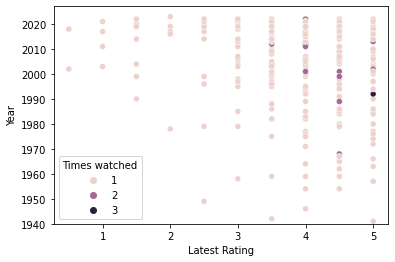

In [82]:
sns.scatterplot(data=df,  x="Latest Rating", y="Year", hue="Times watched")
sns.set_palette("bright")
plt.ylim(1940)

(1940.0, 2044.0400899655992)

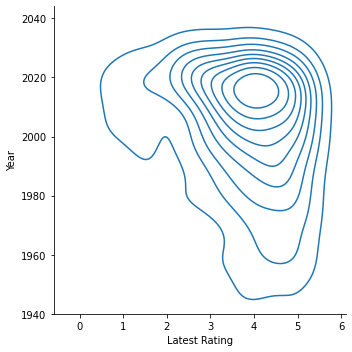

In [76]:
sns.displot(data=df,  x="Latest Rating", y="Year", kind="kde")
plt.ylim(1940)

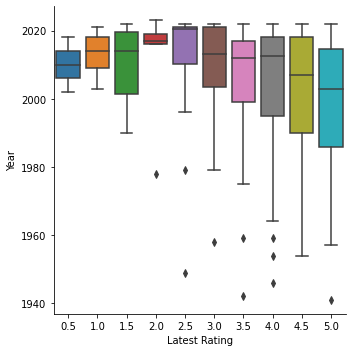

In [31]:
sns.catplot(data=df, x="Latest Rating", y="Year", kind="box")

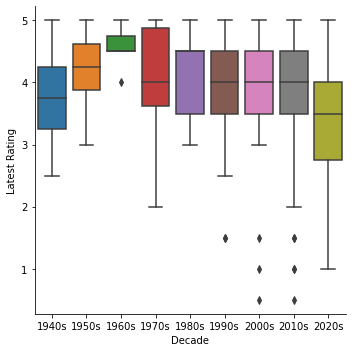

In [61]:
sns.catplot(data=df, x="Decade", y="Latest Rating", kind="box")

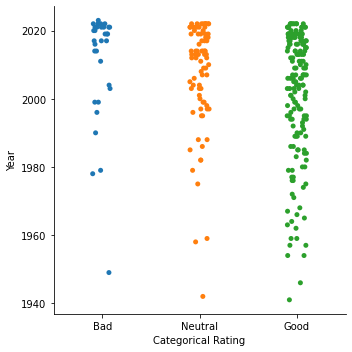

In [68]:
sns.catplot(data=df, y="Year", x="Categorical Rating")